In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 32

In [4]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

In [5]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i  + 1)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=1)

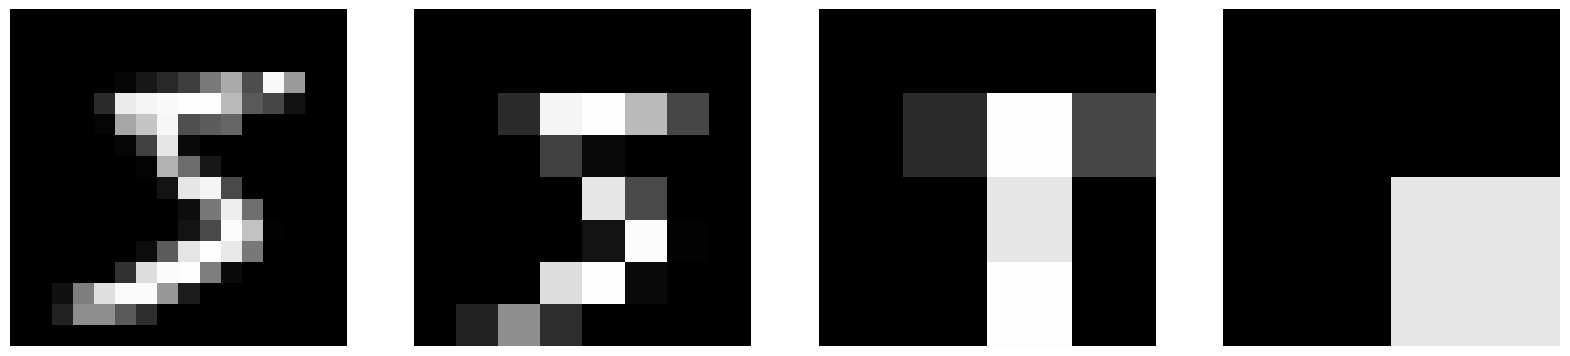

In [8]:
from utils import scale_images

class Pixelate:
    def __init__(
        self,
        n_between: int = 1,
        minimum_pixelation: int = 8,
    ):
        self.n_between = n_between
        self.interpolation = transforms.InterpolationMode.NEAREST
        self.minimum_pixelation = minimum_pixelation

    def calculate_T(self, image_size):
        """Calculate total number of steps based on image size and minimum pixelation"""
        steps = 0
        size = image_size
        while size > self.minimum_pixelation:
            steps += self.n_between + 1
            size //= 2
        
        return steps

    def __call__(self, images: torch.Tensor, t: int):

        if isinstance(t, torch.Tensor):
            t = t.item()

        image_size = images.shape[-1]

        # If not between two image sizes
        if t % (self.n_between + 1) == 0:
            # Find pixelation level
            to_size = image_size // (2 ** (t // (self.n_between + 1)))

            # Pixelate image
            images = scale_images(images, to_size)
            return scale_images(images, image_size)
        else:
            # Find larger image size
            upper_image_size = image_size // (2 ** (t // (self.n_between + 1)))
            lower_image_size = image_size // (2 ** ((t // (self.n_between + 1)) + 1))
            upper_image = scale_images(images, upper_image_size)
            upper_image = scale_images(upper_image, image_size)

            lower_image = scale_images(images, lower_image_size)
            lower_image = scale_images(lower_image, image_size)

            # Interpolate between two images
            interpolation = t / (self.n_between + 1)
            return (1 - interpolation) * upper_image + interpolation * lower_image
        
pixelate = Pixelate(0, 2)

T = pixelate.calculate_T(IMAGE_SIZE)

for i in range(1):
    showImageList([
        pixelate(train_dataset[i][0], t) for t in range(1, T + 1)
    ])

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_36356/210128208.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 5))


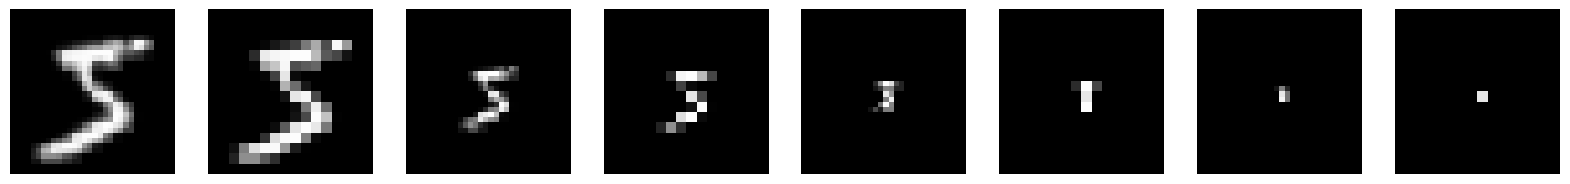

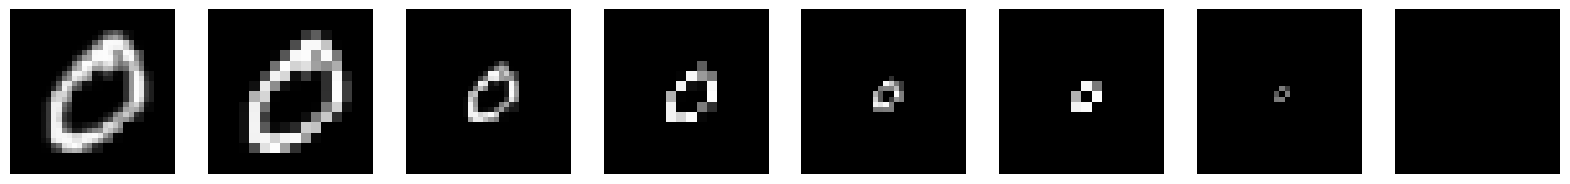

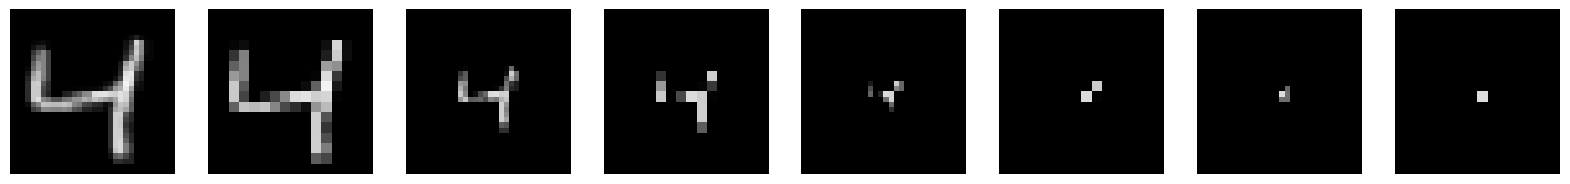

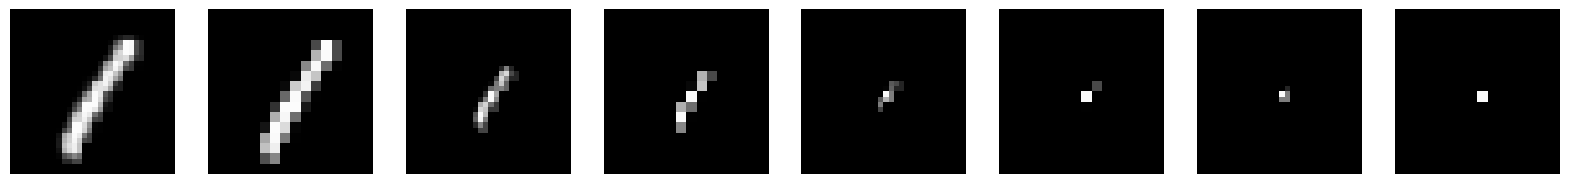

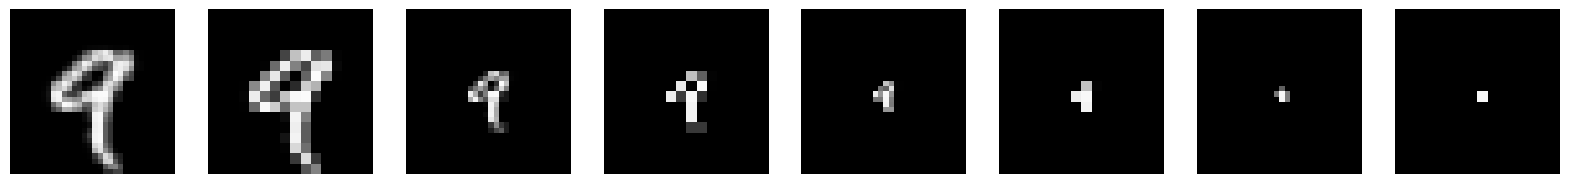

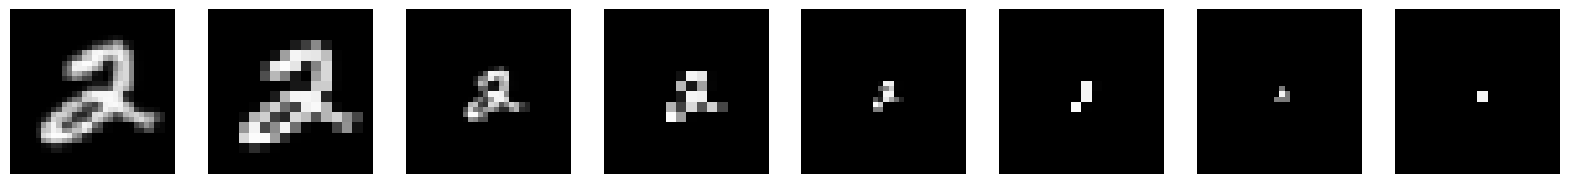

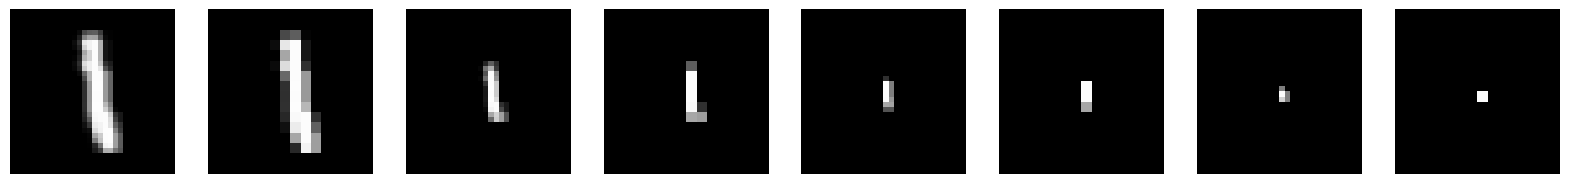

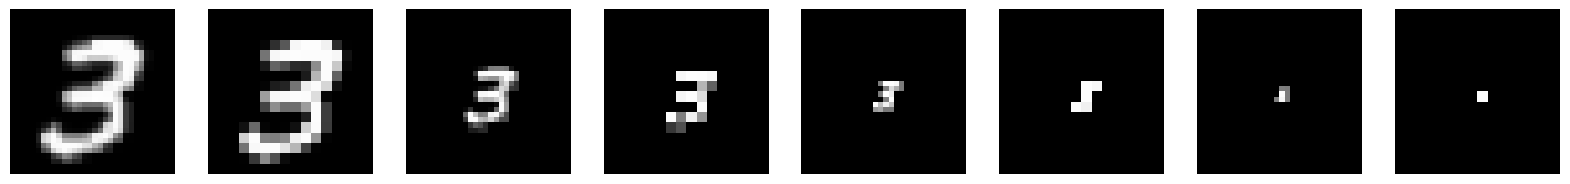

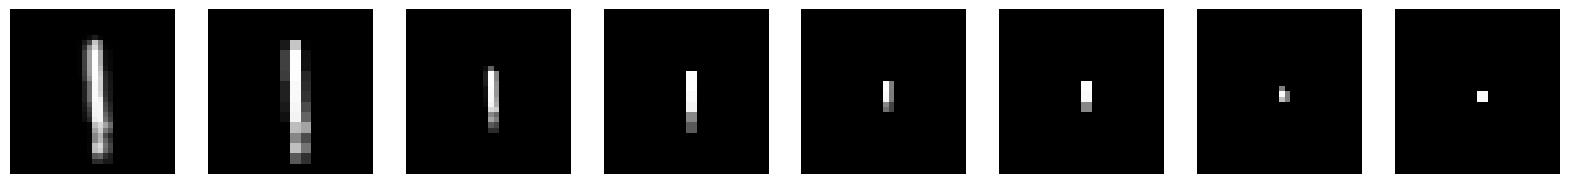

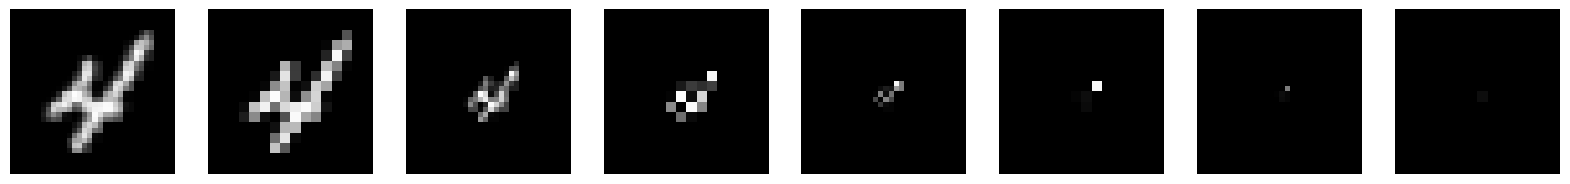

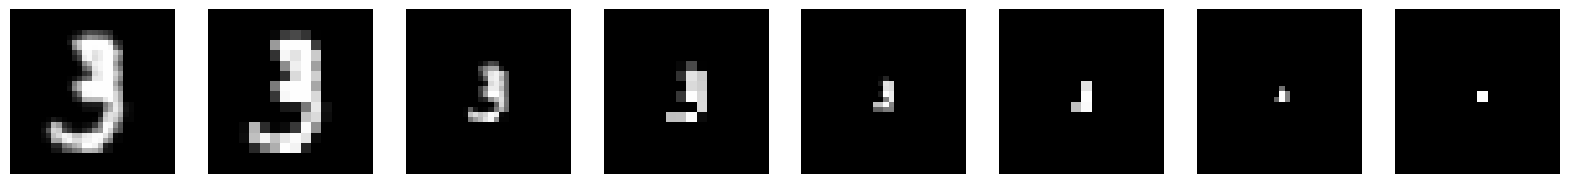

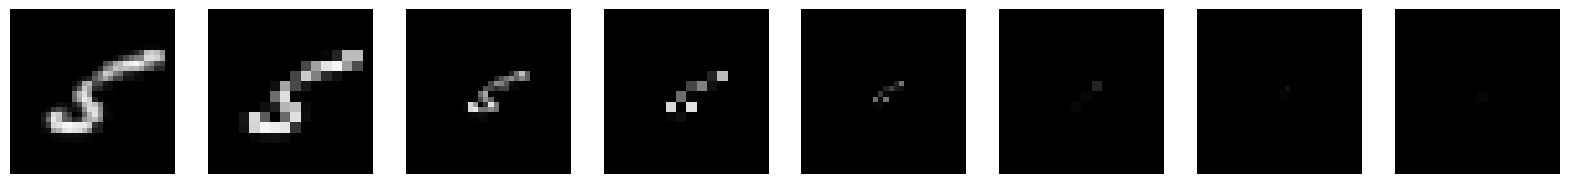

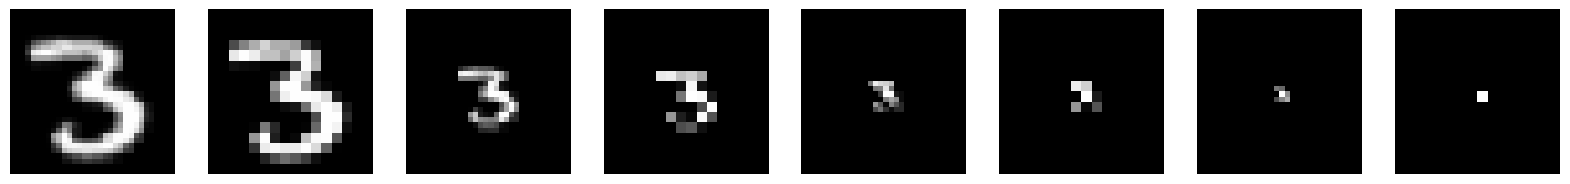

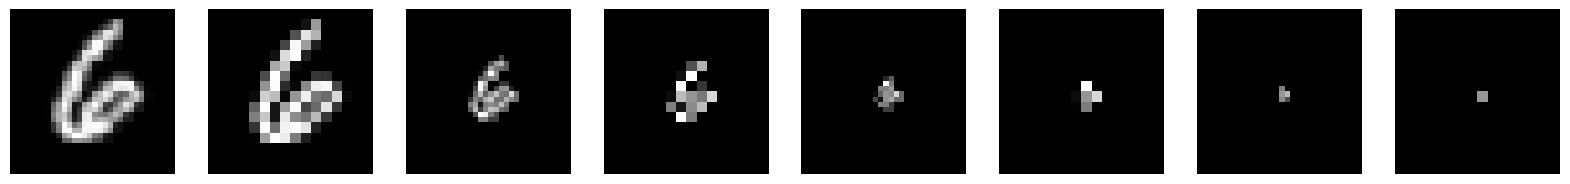

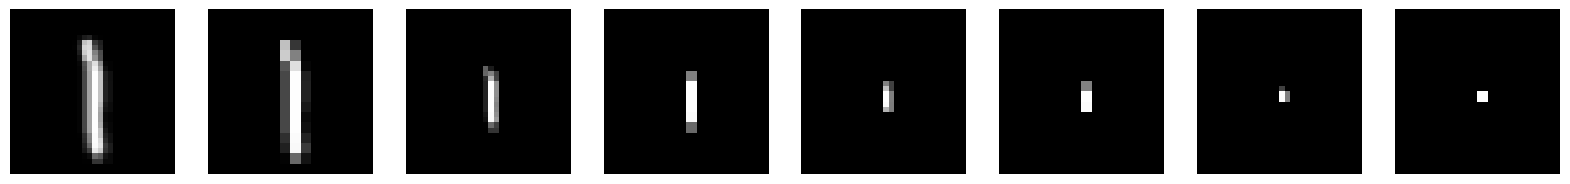

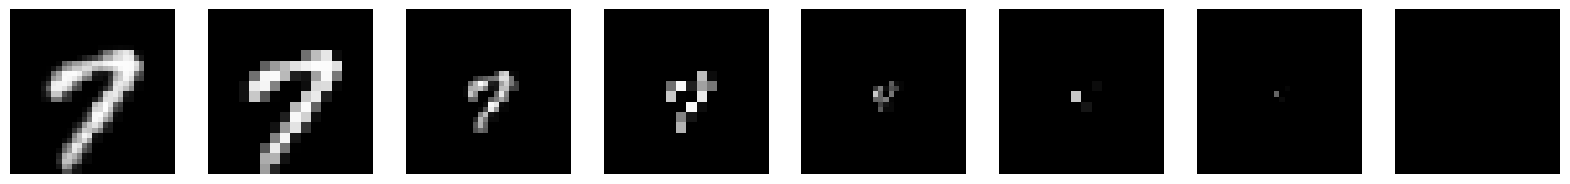

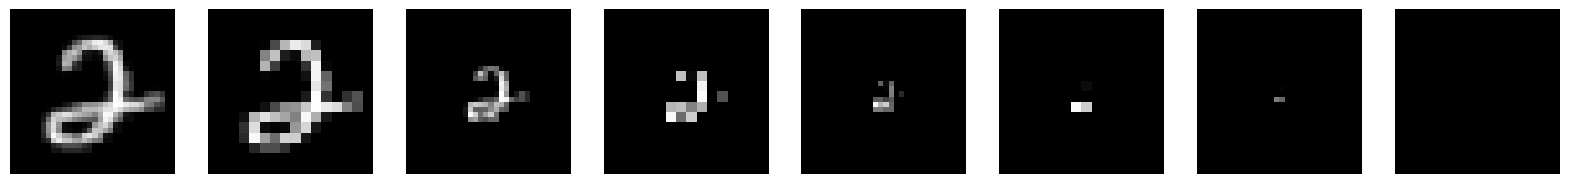

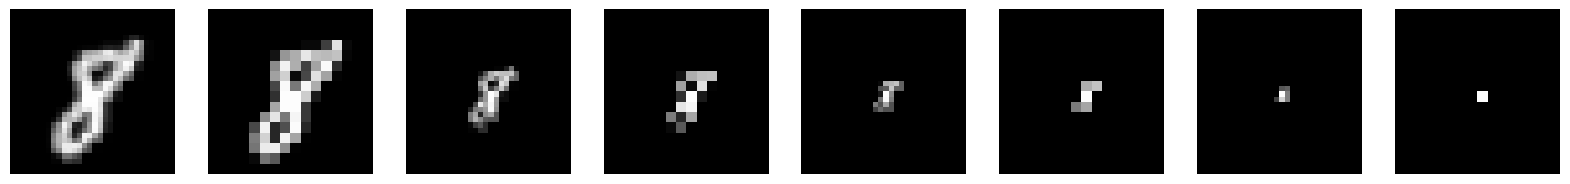

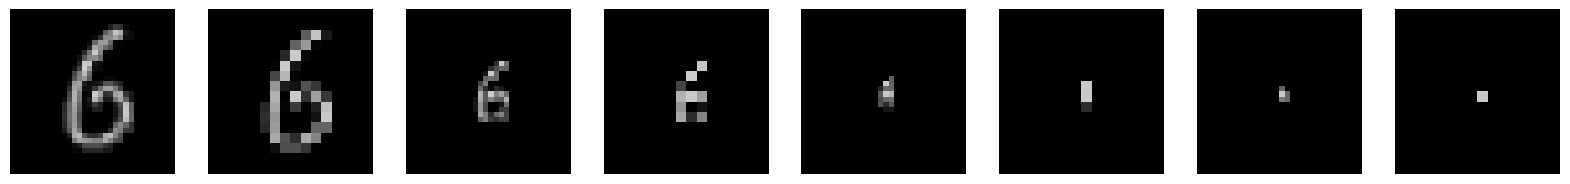

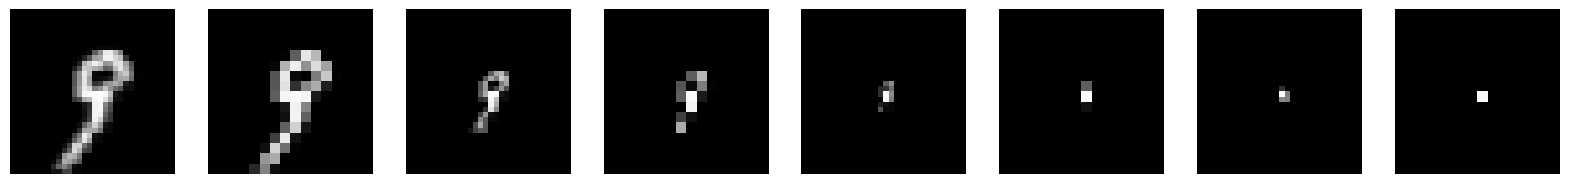

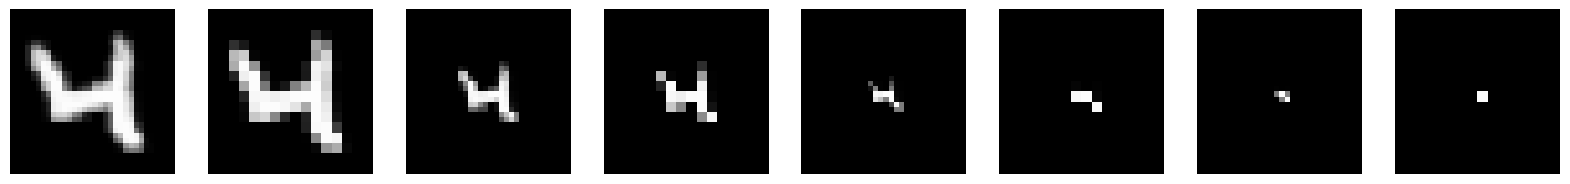

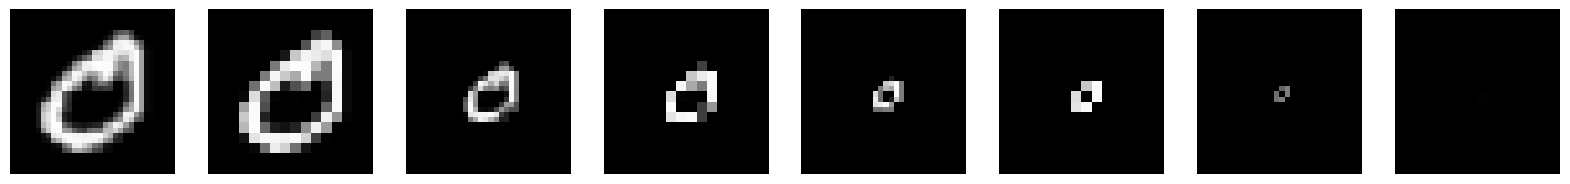

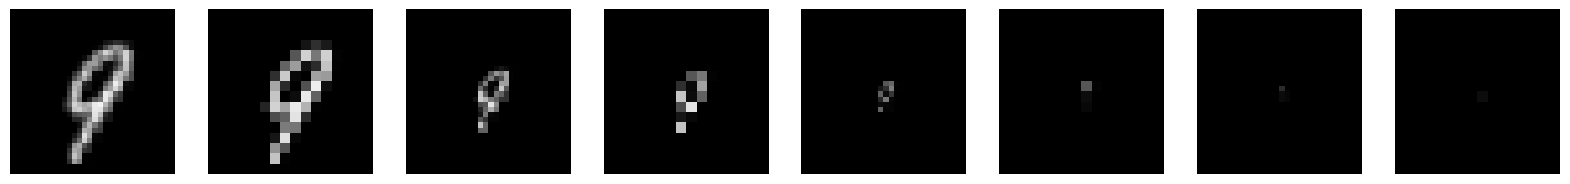

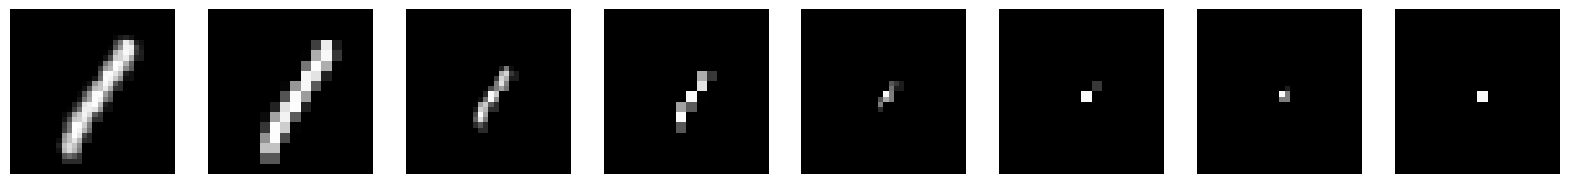

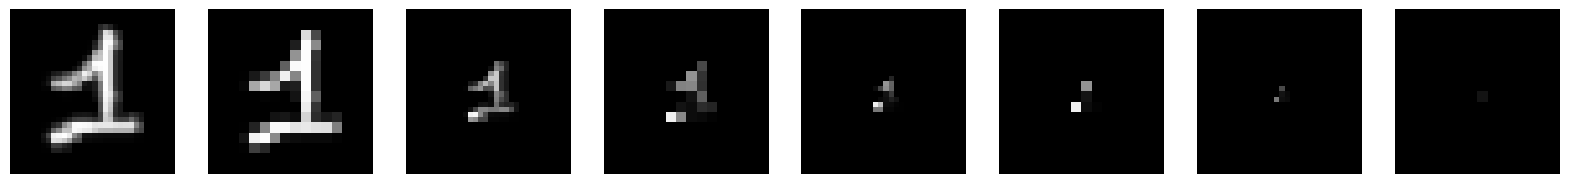

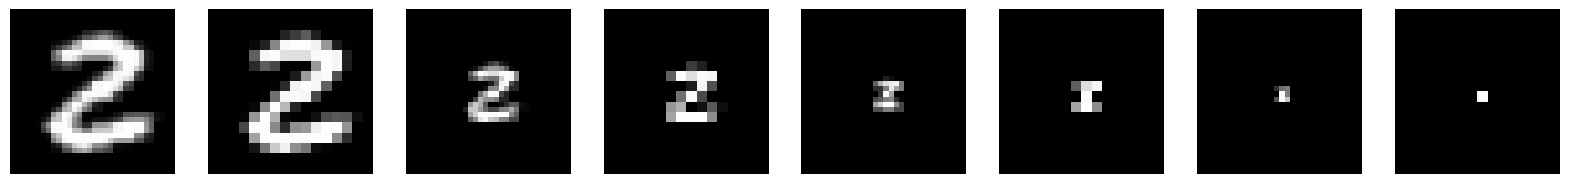

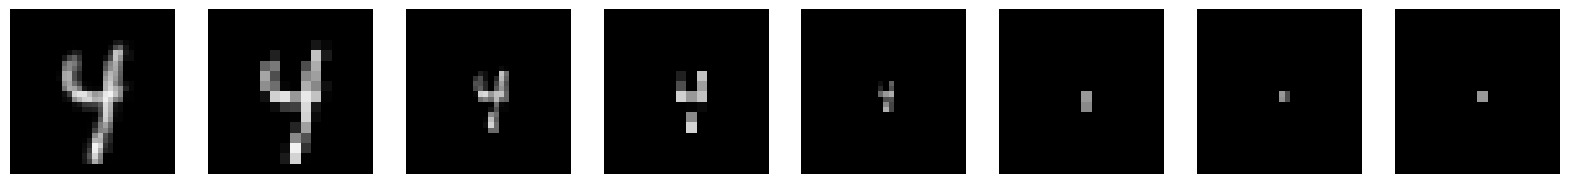

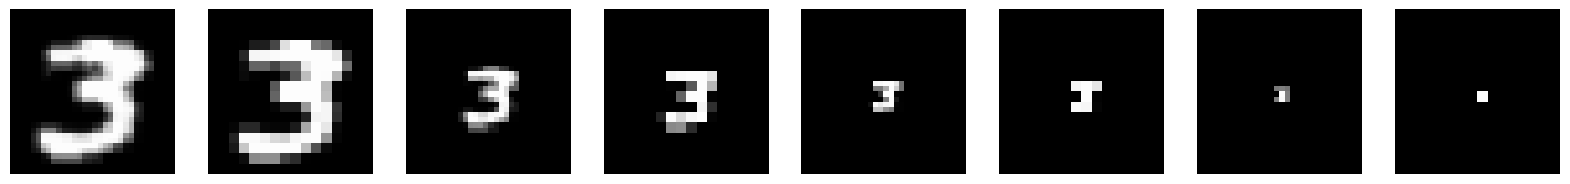

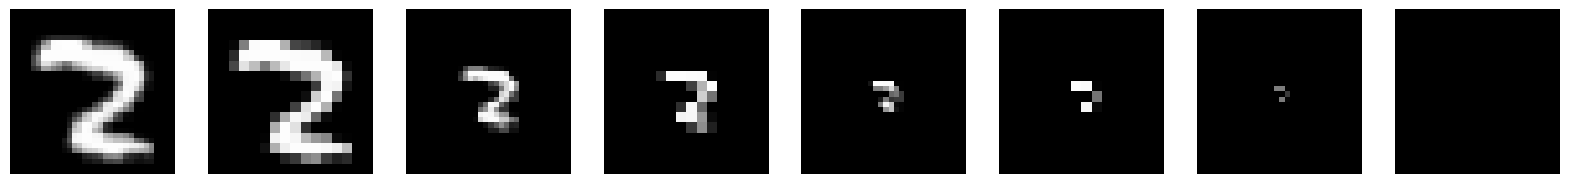

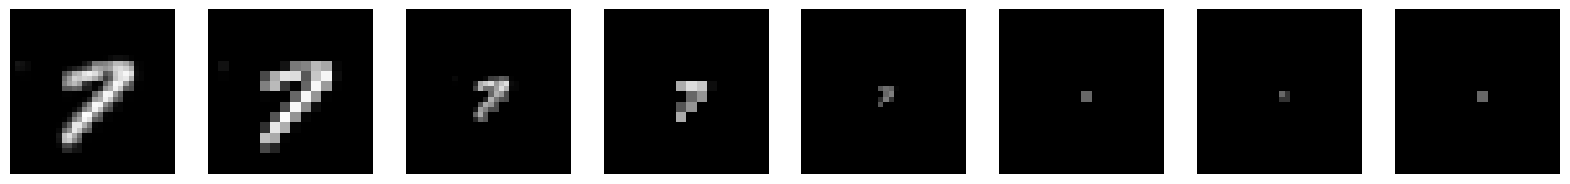

In [24]:
n_between = 1
minimum_pixelation = 2
pixelate = Pixelate(n_between=n_between, minimum_pixelation=minimum_pixelation)
from utils import scale_images
import math


def get_image_time_line(image):
    images = []
    initial_size = image.shape[-1]


    number_of_levels = int(math.log2(initial_size) - math.log2(minimum_pixelation * 2)) + 1

    
    for level in range(0, number_of_levels):
        for relative_t in range(1, n_between + 2):
            # Downscale image
            to_size = initial_size // (2 ** level)
            scaled_image = scale_images(image.unsqueeze(0), to_size)

            # Pixelate image
            pixelated_image = pixelate(scaled_image, relative_t)

            # Pad image
            pad_size = initial_size - pixelated_image.shape[-1]

            pixelated_image = torch.nn.functional.pad(
                pixelated_image,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(pixelated_image)

    return images


for i in range(30):
    showImageList(
        get_image_time_line(train_dataset[i][0])
    )

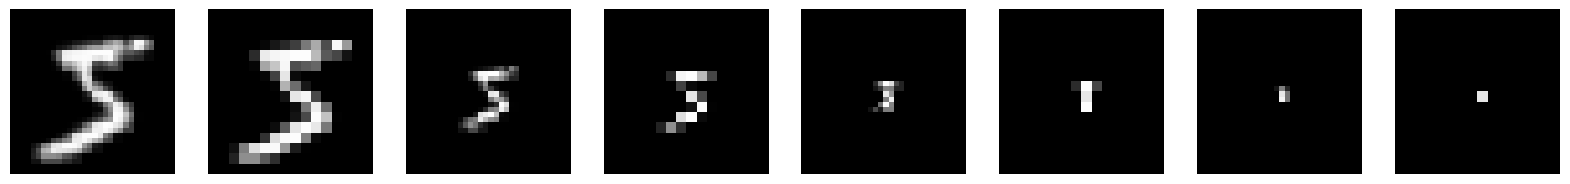

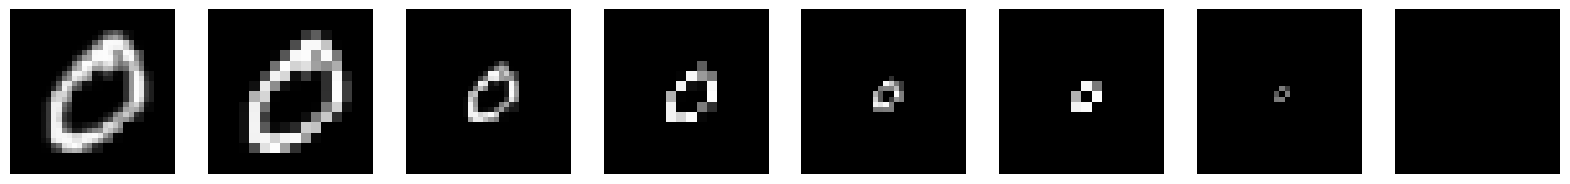

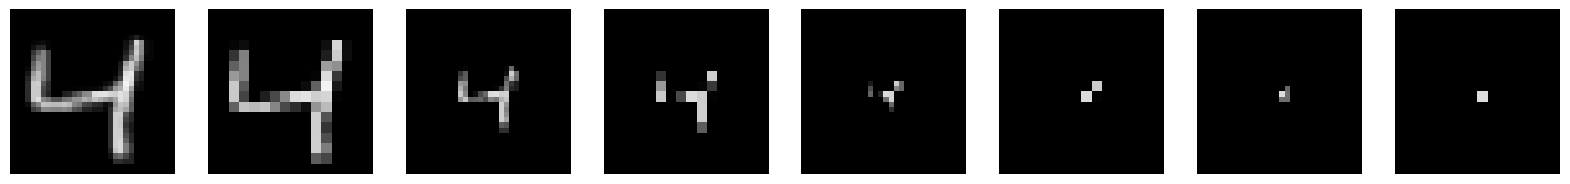

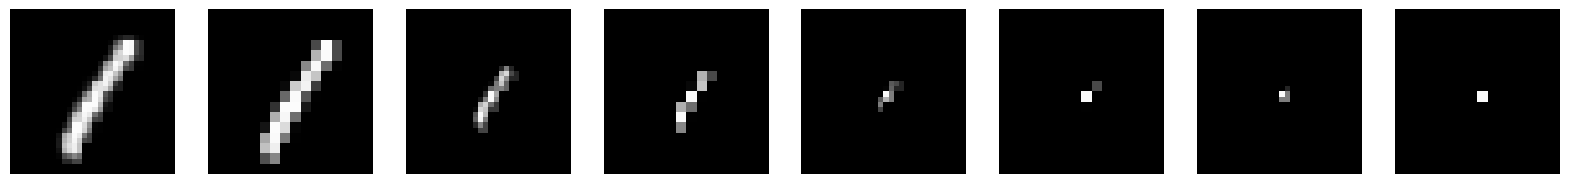

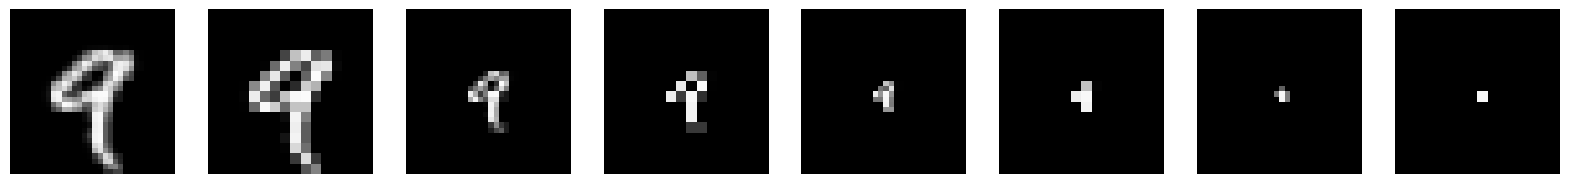

In [31]:
def get_example_sample(image):

    image = image.unsqueeze(0)

    current_size = minimum_pixelation * 2

    x_t = scale_images(image, to_size=minimum_pixelation)
    x_t = scale_images(x_t, to_size=current_size)

    initial_size = image.shape[-1]

    pad_size = initial_size - x_t.shape[-1]

    padded_image = torch.nn.functional.pad(
        x_t,
        pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
    )

    images = [padded_image]

    
    while current_size <= initial_size:
        for relative_t in range(n_between + 1, 0, -1):

            x_0 = scale_images(image, current_size)

            if relative_t - 1 > 0:
                x_t = (
                    x_t
                    - pixelate(x_0, relative_t)
                    + pixelate(x_0, (relative_t - 1))
                )
                # x_t = pixelate(x_0, (relative_t - 1))
            else:
                current_size *= 2
                x_t = scale_images(x_0, current_size)

            

            pad_size = initial_size - x_t.shape[-1]

            padded_image = torch.nn.functional.pad(
                x_t,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(padded_image)


    return images[:-1][::-1]

for i in range(5):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )

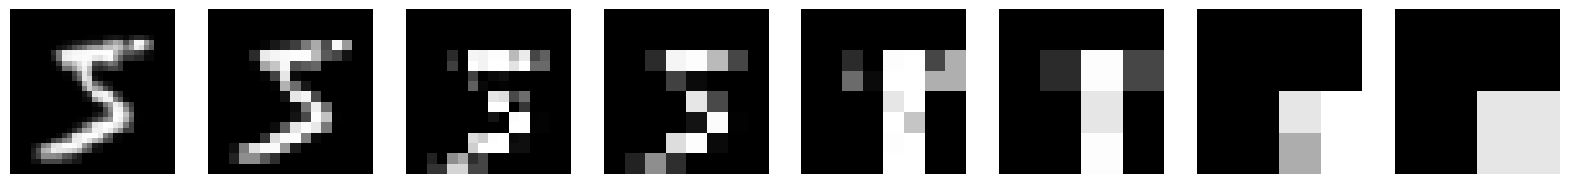

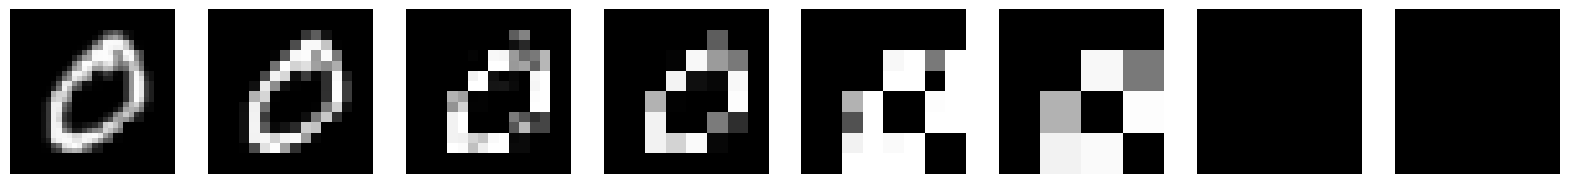

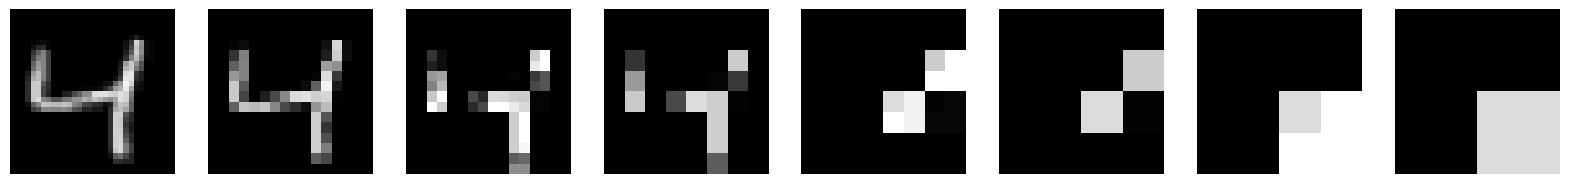

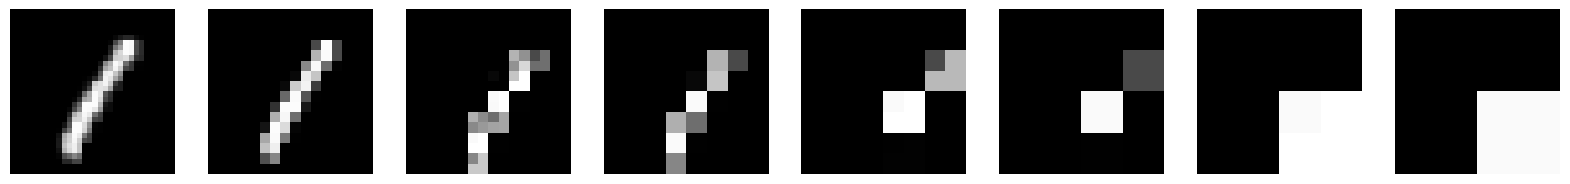

In [27]:

def get_example_sample(image):

    image = image.unsqueeze(0)

    x_t = pixelate(image, T)

    images = [x_t]

    for t in range(T, 1, -1):

        x_t = (
            x_t
            - pixelate(image, t)
            + pixelate(image, (t - 1))
        )
        # x_t = pixelate(image, (t - 1))

        images.append(x_t)


    return images[::-1]

T = pixelate.calculate_T(IMAGE_SIZE)
for i in range(4):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )

In [99]:
class ArithmeticScheduler():
    def get_probabilities(self, number_of_levels):
        prob_dist = [i for i in range(1, number_of_levels + 1)]
        return [p / sum(prob_dist) for p in prob_dist]
    
class PowerScheduler():
    def get_probabilities(self, number_of_levels, power=0.4):
        prob_dist = [i**power for i in range(1, number_of_levels + 1)]
        return [p / sum(prob_dist) for p in prob_dist]
    
class GeometricScheduler():
    def get_probabilities(self, number_of_levels, base=1.5):

        prob_dist = [base**i for i in range(number_of_levels)]
        return [p / sum(prob_dist) for p in prob_dist]
    

scheduler = GeometricScheduler()

scheduler2 = ArithmeticScheduler()
scheduler3 = PowerScheduler()
t = 3
print(scheduler.get_probabilities(t))
print(scheduler2.get_probabilities(t))
print(scheduler3.get_probabilities(t))

[0.21052631578947367, 0.3157894736842105, 0.47368421052631576]
[0.16666666666666666, 0.3333333333333333, 0.5]
[0.25830759292716104, 0.3408389122800935, 0.4008534947927454]
